In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

import math
from sklearn.preprocessing import MinMaxScaler

from yahoo_fin.stock_info import get_data


In [44]:
# #load the data 

# dltr_df= get_data("DLTR", start_date="01/01/2014", end_date="08/23/2022", index_as_date = False, interval="1wk")
# dltr_df

lulu_df = pd.read_csv('LULU.csv')


#This is the issue i was running into " EOL while scanning string literal"
#So this is they wasy that I had to do it. 

In [45]:
lulu_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-24,46.799999,48.169998,46.750000,47.619999,47.619999,7198300
1,2014-01-27,47.470001,47.599998,45.540001,46.270000,46.270000,4565100
2,2014-01-28,46.099998,47.180000,46.099998,46.709999,46.709999,2034200
3,2014-01-29,46.180000,46.480000,45.400002,45.680000,45.680000,2471600
4,2014-01-30,46.220001,47.240002,45.410000,46.820000,46.820000,3650700


In [46]:
#Inspect it 
print(lulu_df)

            Date        Open        High         Low       Close   Adj Close  \
0     2014-01-24   46.799999   48.169998   46.750000   47.619999   47.619999   
1     2014-01-27   47.470001   47.599998   45.540001   46.270000   46.270000   
2     2014-01-28   46.099998   47.180000   46.099998   46.709999   46.709999   
3     2014-01-29   46.180000   46.480000   45.400002   45.680000   45.680000   
4     2014-01-30   46.220001   47.240002   45.410000   46.820000   46.820000   
...          ...         ...         ...         ...         ...         ...   
2156  2022-08-17  327.529999  332.500000  324.510010  329.799988  329.799988   
2157  2022-08-18  330.570007  334.959991  328.510010  333.420013  333.420013   
2158  2022-08-19  328.480011  329.019989  321.320007  322.470001  322.470001   
2159  2022-08-22  317.119995  321.489990  313.519989  315.220001  315.220001   
2160  2022-08-23  315.350006  322.549988  314.690002  315.929993  315.929993   

       Volume  
0     7198300  
1     4

In [47]:
#print the summary 
print(lulu_df.describe())

              Open         High          Low        Close    Adj Close  \
count  2161.000000  2161.000000  2161.000000  2161.000000  2161.000000   
mean    162.158561   164.454674   159.658533   162.119533   162.119533   
std     123.319243   125.024275   121.260991   123.178050   123.178050   
min      37.150002    37.639999    36.259998    37.250000    37.250000   
25%      61.240002    61.900002    60.369999    61.230000    61.230000   
50%      99.309998    99.910004    98.309998    99.169998    99.169998   
75%     283.209991   291.309998   278.000000   284.640015   284.640015   
max     476.779999   485.829987   469.089996   477.910004   477.910004   

             Volume  
count  2.161000e+03  
mean   2.182357e+06  
std    2.325959e+06  
min    3.974000e+05  
25%    1.207500e+06  
50%    1.682400e+06  
75%    2.422700e+06  
max    4.962030e+07  


In [48]:
#now prep the data for 2014-2019
lulu_df.set_index(pd.DatetimeIndex(lulu_df['Date']), inplace=True)

In [49]:
#Keep the close for 2014-19
lulu_df = lulu_df[['Close']]

In [50]:
print(lulu_df)

                 Close
Date                  
2014-01-24   47.619999
2014-01-27   46.270000
2014-01-28   46.709999
2014-01-29   45.680000
2014-01-30   46.820000
...                ...
2022-08-17  329.799988
2022-08-18  333.420013
2022-08-19  322.470001
2022-08-22  315.220001
2022-08-23  315.929993

[2161 rows x 1 columns]


In [51]:


data = lulu_df.filter(['Close'])
dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len =math.ceil(len(dataset) *.7)
train_data =scaled_data[0:training_data_len , : ]

X_train_data = []
y_train_data = []

for i in range(1500,len(train_data)):
    X_train_data=list(X_train_data)
    y_train_data=list(y_train_data)
    X_train_data.append(train_data[i-1500:i,0])
    y_train_data.append(train_data[i,0])
    
    X_train_data1, y_train_data1 = np.array(X_train_data), np.array(y_train_data)
    
    X_train_data2 = np.reshape(X_train_data1,(X_train_data1.shape[0],X_train_data1.shape[1],1))

#1500 = number of days 
# There will be a total of 60 values, 1st column will contain an index of 0-59
# The second will have an index of 1-60 ++_
# the y_train has the 60 st value on c1 and c2 will have 61++

In [52]:
#Lets build the LSTM MODEL 

model = Sequential()

model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train_data2.shape[1],1)))

model.add(LSTM(units=50, return_sequences=False))

model.add(Dense(units=25))

model.add(Dense(units=1))


#okay this example will have 2 LSTM layers w/50 neurons and 2 dense layers
# plust one with 25 nuerons 

In [53]:
# Comple the model 

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_data2, y_train_data1, batch_size=1, epochs=1)

13/13 [==============================] - 8s 432ms/step - loss: 0.0686


In [54]:
test_data = scaled_data[training_data_len -1500: , : ]

X_test = []

y_test = dataset[training_data_len : , : ]

for i in range(1500,len(test_data)):
    
    X_test.append(test_data[i-1500:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)


21/21 [==============================] - 5s 199ms/step


In [55]:
# Error calculation where RMSE = root mean squared error 

rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

In [56]:
print(rmse)

27.61563828278423


In [57]:
#OOOF okay the lower the value is to 0 the better
# it indicates that the models p-value match the actual values from the data set 
# which in this case it does not. 

/Users/dashickscott/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


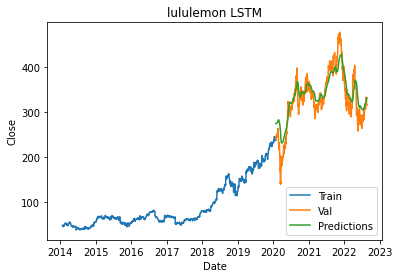

In [59]:
#Predict and visualize 

train = lulu_df[:training_data_len]

valid = lulu_df[training_data_len:]

valid['Predictions'] = predictions

plt.title('lululemon LSTM')

plt.xlabel('Date')

plt.ylabel('Close')

plt.plot(train['Close'])

plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()


<AxesSubplot:xlabel='Date'>

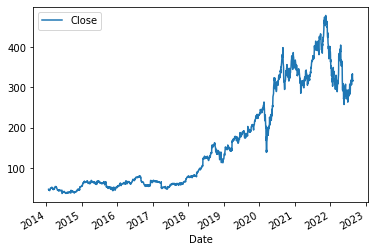

In [17]:
lulu_df.plot()

In [18]:
train['Close']

Date
2014-01-24     47.619999
2014-01-27     46.270000
2014-01-28     46.709999
2014-01-29     45.680000
2014-01-30     46.820000
                 ...    
2020-01-22    244.300003
2020-01-23    243.059998
2020-01-24    240.350006
2020-01-27    236.740005
2020-01-28    239.350006
Name: Close, Length: 1513, dtype: float64

In [19]:
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2020-01-29,243.660004,249.974167
2020-01-30,243.770004,250.159698
2020-01-31,239.389999,250.376999
2020-02-03,246.369995,250.502075
2020-02-04,247.990005,250.727356
...,...,...
2022-08-17,329.799988,299.769257
2022-08-18,333.420013,301.068970
2022-08-19,322.470001,302.405243


In [20]:
complete_df = pd.concat([train[['Close']], valid[['Close', 'Predictions']]])
complete_df

,Close,Predictions
Date,,
2014-01-24,47.619999,NaN
2014-01-27,46.270000,NaN
2014-01-28,46.709999,NaN
2014-01-29,45.680000,NaN
2014-01-30,46.820000,NaN
...,...,...
2022-08-17,329.799988,299.769257
2022-08-18,333.420013,301.068970
2022-08-19,322.470001,302.405243


In [21]:
complete_df.head()

,Close,Predictions
Date,,
2014-01-24,47.619999,NaN
2014-01-27,46.270000,NaN
2014-01-28,46.709999,NaN
2014-01-29,45.680000,NaN
2014-01-30,46.820000,NaN


In [24]:
complete_df2 = complete_df.dropna()

print(complete_df2)

                 Close  Predictions
Date                               
2020-01-29  243.660004   249.974167
2020-01-30  243.770004   250.159698
2020-01-31  239.389999   250.376999
2020-02-03  246.369995   250.502075
2020-02-04  247.990005   250.727356
...                ...          ...
2022-08-17  329.799988   299.769257
2022-08-18  333.420013   301.068970
2022-08-19  322.470001   302.405243
2022-08-22  315.220001   303.460480
2022-08-23  315.929993   304.113647

[648 rows x 2 columns]


In [26]:

# complete_df2 = pd.DataFrame(complete_df2,columns= ['Date','Close','Predictions','Difference'])
   
complete_df2['Difference'] = complete_df2['Close'] - complete_df2['Predictions'] 

/Users/dashickscott/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
complete_df2


,Close,Predictions,Difference
Date,,,
2020-01-29,243.660004,249.974167,-6.314163
2020-01-30,243.770004,250.159698,-6.389694
2020-01-31,239.389999,250.376999,-10.987000
2020-02-03,246.369995,250.502075,-4.132080
2020-02-04,247.990005,250.727356,-2.737351
...,...,...,...
2022-08-17,329.799988,299.769257,30.030731
2022-08-18,333.420013,301.068970,32.351043
2022-08-19,322.470001,302.405243,20.064758


In [30]:
#Get rid of these zeros 
complete_df2.loc[~(complete_df2==0).all(axis=1)]

,Close,Predictions,Difference
Date,,,
2020-01-29,243.660004,249.974167,-6.314163
2020-01-30,243.770004,250.159698,-6.389694
2020-01-31,239.389999,250.376999,-10.987000
2020-02-03,246.369995,250.502075,-4.132080
2020-02-04,247.990005,250.727356,-2.737351
...,...,...,...
2022-08-17,329.799988,299.769257,30.030731
2022-08-18,333.420013,301.068970,32.351043
2022-08-19,322.470001,302.405243,20.064758


In [31]:
complete_df2.style.format({
    'Close': '{:,.2f}'.format,
    'Predictions': '{:,.2f}'.format,
    'Difference': '{:,.2f}'.format,
})

,Close,Predictions,Difference
Date,,,
2020-01-29 00:00:00,243.66,249.97,-6.31
2020-01-30 00:00:00,243.77,250.16,-6.39
2020-01-31 00:00:00,239.39,250.38,-10.99
2020-02-03 00:00:00,246.37,250.50,-4.13
2020-02-04 00:00:00,247.99,250.73,-2.74
2020-02-05 00:00:00,243.90,251.05,-7.15
2020-02-06 00:00:00,243.78,251.34,-7.56
2020-02-07 00:00:00,243.51,251.58,-8.07
2020-02-10 00:00:00,248.54,251.78,-3.24


In [34]:
complete_df3

,Close,Predictions,Difference
Date,,,
2020-01-29,243.660004,249.974167,-6.314163
2020-01-30,243.770004,250.159698,-6.389694
2020-01-31,239.389999,250.376999,-10.987000
2020-02-03,246.369995,250.502075,-4.132080
2020-02-04,247.990005,250.727356,-2.737351
...,...,...,...
2022-08-17,329.799988,299.769257,30.030731
2022-08-18,333.420013,301.068970,32.351043
2022-08-19,322.470001,302.405243,20.064758


In [42]:
complete_df2.to_csv('AP_lulu.csv', index=False)